# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

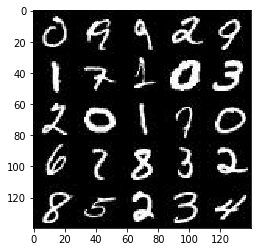

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

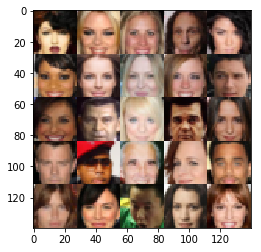

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=())
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, alpha):
    return tf.maximum(x, alpha * x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    training = True
    alpha = 0.01
    drop_rate = 0.2

    def conv_layer(prev_layer, layer_depth, with_batch_normalization=True):
        layer = tf.layers.conv2d(prev_layer, layer_depth, kernel_size=5, strides=2, padding='same', use_bias=False, activation=None,
                                kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=training)
        layer = tf.layers.dropout(layer, rate=drop_rate)
        layer = leaky_relu(layer, alpha)
        return layer

    with tf.variable_scope("discriminator", reuse=reuse):
        layer = conv_layer(images, layer_depth=16, with_batch_normalization=False)
        layer_depths = [32, 64]
        for layer_depth in layer_depths:
            prev_layer = layer
            layer = conv_layer(prev_layer, layer_depth)

        orig_shape = layer.get_shape().as_list()
        conv_layer = tf.reshape(layer, shape=(-1, orig_shape[1] * orig_shape[2] * orig_shape[3]))

        logits = tf.layers.dense(conv_layer, 1, activation=None)
        out = tf.nn.sigmoid(logits) 

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, drop_rate=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    
    def full_connected(pre_layer, num_units):
        layer = tf.layers.dense(pre_layer, num_units, use_bias=False, activation=None,
                               kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.layers.dropout(layer, rate=drop_rate)
        layer = leaky_relu(layer, alpha)
        return layer
    
    def conv_layer(prev_layer, layer_depth):
        layer = tf.layers.conv2d_transpose(prev_layer, layer_depth, kernel_size=5, strides=2, padding='same', use_bias=False, activation=None,
                                          kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.layers.dropout(layer, rate=drop_rate)
        layer = leaky_relu(layer, alpha)
        return layer

    with tf.variable_scope("generator", reuse=False if is_train==True else True):
        x = full_connected(z, 7*7*512)
        x = tf.reshape(x, shape=(-1, 7, 7, 512))

        layer_depths = [256, 128] # 14*14*256, 28*28*128
        layer = x
        for layer_depth in layer_depths:
            prev_layer = layer
            layer = conv_layer(prev_layer, layer_depth)

        logits = tf.layers.conv2d_transpose(layer, out_channel_dim, kernel_size=5, strides=1, padding='same', activation=None)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False, drop_rate=0.0),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every=10
    show_every=100
    n_sample_images = 25
    steps = 0
    losses = []
   
    batches, image_width, image_height, image_channels = data_shape
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()   
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2.0
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_sample_images, input_z, image_channels, data_image_mode)
        saver.save(sess, './checkpoints/generator.ckpt')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0584... Generator Loss: 3.2241
Epoch 1/2... Discriminator Loss: 0.0338... Generator Loss: 4.3485
Epoch 1/2... Discriminator Loss: 0.0109... Generator Loss: 5.3706
Epoch 1/2... Discriminator Loss: 0.0122... Generator Loss: 5.2305
Epoch 1/2... Discriminator Loss: 0.0804... Generator Loss: 2.9383
Epoch 1/2... Discriminator Loss: 0.1339... Generator Loss: 3.2819
Epoch 1/2... Discriminator Loss: 0.2455... Generator Loss: 3.2030
Epoch 1/2... Discriminator Loss: 0.2601... Generator Loss: 3.6477
Epoch 1/2... Discriminator Loss: 0.3198... Generator Loss: 2.0799
Epoch 1/2... Discriminator Loss: 3.7978... Generator Loss: 0.0519


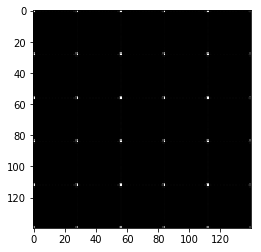

Epoch 1/2... Discriminator Loss: 1.4198... Generator Loss: 0.5059
Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 0.6372
Epoch 1/2... Discriminator Loss: 2.2162... Generator Loss: 0.1690
Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 0.5909
Epoch 1/2... Discriminator Loss: 1.6558... Generator Loss: 0.3049
Epoch 1/2... Discriminator Loss: 1.4714... Generator Loss: 0.4088
Epoch 1/2... Discriminator Loss: 1.1841... Generator Loss: 0.9536
Epoch 1/2... Discriminator Loss: 1.9821... Generator Loss: 0.2291
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.4706
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.8356


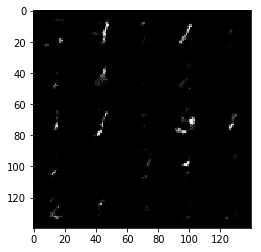

Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 0.9013
Epoch 1/2... Discriminator Loss: 1.4757... Generator Loss: 0.3986
Epoch 1/2... Discriminator Loss: 1.7130... Generator Loss: 0.2872
Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 1.5170
Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 1.9670
Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 1.8775
Epoch 1/2... Discriminator Loss: 2.2688... Generator Loss: 0.1343
Epoch 1/2... Discriminator Loss: 1.3855... Generator Loss: 0.8079
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.5564
Epoch 1/2... Discriminator Loss: 1.6307... Generator Loss: 0.3168


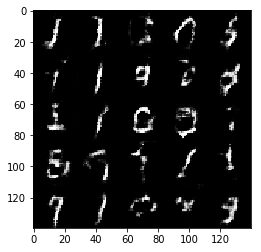

Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 1.0453
Epoch 1/2... Discriminator Loss: 1.2867... Generator Loss: 0.7333
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.2376... Generator Loss: 0.6057
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 0.5399
Epoch 1/2... Discriminator Loss: 1.5063... Generator Loss: 0.3702
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.6625
Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 0.7630
Epoch 1/2... Discriminator Loss: 1.6841... Generator Loss: 0.2774
Epoch 1/2... Discriminator Loss: 1.1589... Generator Loss: 1.9676


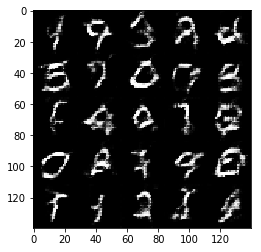

Epoch 1/2... Discriminator Loss: 1.5116... Generator Loss: 0.6859
Epoch 1/2... Discriminator Loss: 2.0711... Generator Loss: 0.1820
Epoch 1/2... Discriminator Loss: 1.2487... Generator Loss: 0.9396
Epoch 1/2... Discriminator Loss: 1.6911... Generator Loss: 0.3332
Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.4725
Epoch 1/2... Discriminator Loss: 1.4420... Generator Loss: 0.6363
Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 0.9046
Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.5400
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.5690
Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 0.6493


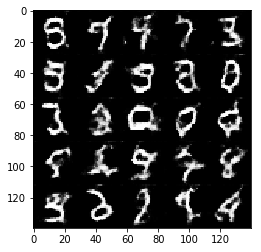

Epoch 1/2... Discriminator Loss: 1.3732... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 0.6016
Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 1.5000... Generator Loss: 0.5050
Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 0.6290
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.4946
Epoch 1/2... Discriminator Loss: 1.3066... Generator Loss: 0.5390
Epoch 1/2... Discriminator Loss: 1.5095... Generator Loss: 0.3645
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.6319
Epoch 1/2... Discriminator Loss: 1.5942... Generator Loss: 0.3558


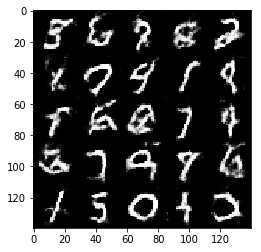

Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 0.6994
Epoch 1/2... Discriminator Loss: 1.5682... Generator Loss: 0.3652
Epoch 1/2... Discriminator Loss: 1.6223... Generator Loss: 0.2866
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 0.5906
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 0.5368
Epoch 1/2... Discriminator Loss: 1.3563... Generator Loss: 0.6606
Epoch 1/2... Discriminator Loss: 1.6254... Generator Loss: 0.2842
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.5341
Epoch 1/2... Discriminator Loss: 1.4658... Generator Loss: 0.3867


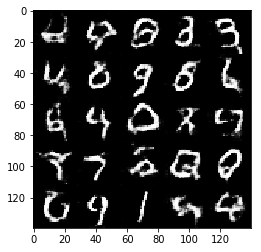

Epoch 1/2... Discriminator Loss: 1.7525... Generator Loss: 0.2656
Epoch 1/2... Discriminator Loss: 1.4270... Generator Loss: 0.4720
Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 0.9485
Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 0.7316
Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 0.7847
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.4364
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.5621
Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 0.6886
Epoch 1/2... Discriminator Loss: 1.4821... Generator Loss: 0.3945


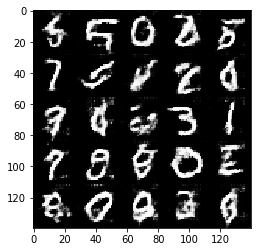

Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.5109
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.5707
Epoch 1/2... Discriminator Loss: 1.6317... Generator Loss: 0.2972
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.6151
Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 1.8680... Generator Loss: 0.2320
Epoch 1/2... Discriminator Loss: 1.3099... Generator Loss: 0.5724
Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 0.5883
Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.6126
Epoch 1/2... Discriminator Loss: 1.6771... Generator Loss: 0.2853


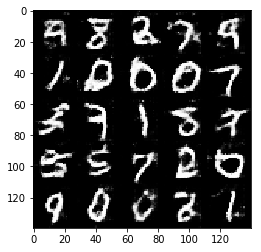

Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 0.6082
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.9929
Epoch 1/2... Discriminator Loss: 1.2466... Generator Loss: 0.6857
Epoch 1/2... Discriminator Loss: 1.4139... Generator Loss: 0.4904
Epoch 1/2... Discriminator Loss: 1.5304... Generator Loss: 0.4000
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 0.6153
Epoch 1/2... Discriminator Loss: 1.2298... Generator Loss: 0.7928
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 0.8481
Epoch 1/2... Discriminator Loss: 1.4754... Generator Loss: 0.3675
Epoch 1/2... Discriminator Loss: 1.5012... Generator Loss: 0.4229


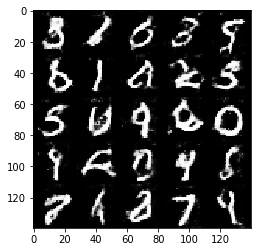

Epoch 1/2... Discriminator Loss: 1.3838... Generator Loss: 0.5430
Epoch 1/2... Discriminator Loss: 1.3221... Generator Loss: 0.7112
Epoch 1/2... Discriminator Loss: 1.4989... Generator Loss: 0.4001
Epoch 1/2... Discriminator Loss: 1.5428... Generator Loss: 0.3808
Epoch 1/2... Discriminator Loss: 1.2859... Generator Loss: 0.8526
Epoch 1/2... Discriminator Loss: 1.5291... Generator Loss: 0.3787
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.8218
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.4133
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 0.7062
Epoch 1/2... Discriminator Loss: 1.4036... Generator Loss: 0.6609


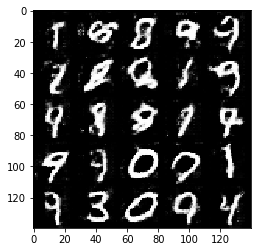

Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 1.1572... Generator Loss: 0.7325
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 0.5444
Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 0.5904
Epoch 1/2... Discriminator Loss: 1.4590... Generator Loss: 0.3954
Epoch 1/2... Discriminator Loss: 1.2140... Generator Loss: 0.7801
Epoch 1/2... Discriminator Loss: 1.2306... Generator Loss: 0.7606
Epoch 1/2... Discriminator Loss: 1.2106... Generator Loss: 0.8670
Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 1.5024... Generator Loss: 0.4437


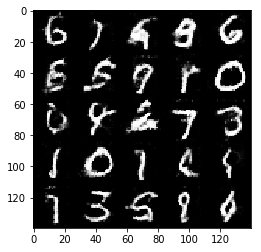

Epoch 1/2... Discriminator Loss: 1.3422... Generator Loss: 0.4876
Epoch 1/2... Discriminator Loss: 1.2613... Generator Loss: 0.7577
Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 0.8069
Epoch 1/2... Discriminator Loss: 1.1146... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 1.5983... Generator Loss: 0.3412
Epoch 1/2... Discriminator Loss: 1.5162... Generator Loss: 0.4078
Epoch 1/2... Discriminator Loss: 1.4780... Generator Loss: 0.3924
Epoch 1/2... Discriminator Loss: 1.1926... Generator Loss: 0.9444
Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 0.5136
Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 0.7133


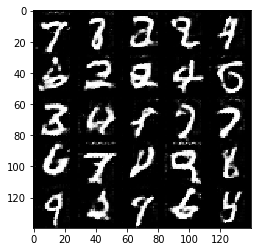

Epoch 1/2... Discriminator Loss: 1.4035... Generator Loss: 0.4167
Epoch 1/2... Discriminator Loss: 1.4790... Generator Loss: 0.3687
Epoch 1/2... Discriminator Loss: 1.2482... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 1.3615... Generator Loss: 0.5167
Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 0.6366
Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 0.3918
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.4186
Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 0.3416
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 0.5558
Epoch 1/2... Discriminator Loss: 1.6365... Generator Loss: 0.3116


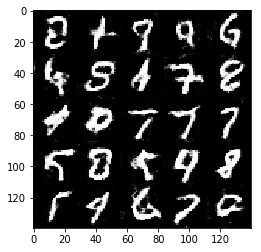

Epoch 1/2... Discriminator Loss: 1.7566... Generator Loss: 0.3010
Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 0.5974
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.4594
Epoch 1/2... Discriminator Loss: 1.3340... Generator Loss: 0.6542
Epoch 1/2... Discriminator Loss: 1.0440... Generator Loss: 0.7442
Epoch 1/2... Discriminator Loss: 1.0442... Generator Loss: 0.7909
Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 1.4066
Epoch 1/2... Discriminator Loss: 1.4734... Generator Loss: 0.4104
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.5961
Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.4760


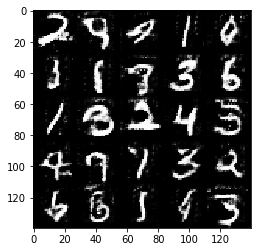

Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 0.4586
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.6118
Epoch 1/2... Discriminator Loss: 1.3722... Generator Loss: 0.4860
Epoch 1/2... Discriminator Loss: 1.0404... Generator Loss: 0.7840
Epoch 1/2... Discriminator Loss: 1.4634... Generator Loss: 0.3728
Epoch 1/2... Discriminator Loss: 1.4444... Generator Loss: 0.4322
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.7503
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 0.6618
Epoch 1/2... Discriminator Loss: 1.6142... Generator Loss: 0.3176
Epoch 1/2... Discriminator Loss: 1.2821... Generator Loss: 0.4993


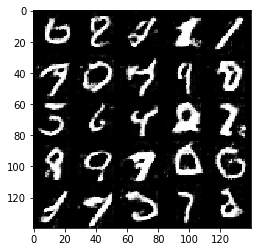

Epoch 1/2... Discriminator Loss: 1.4991... Generator Loss: 0.3829
Epoch 1/2... Discriminator Loss: 1.2387... Generator Loss: 0.5882
Epoch 1/2... Discriminator Loss: 1.0381... Generator Loss: 1.1132
Epoch 1/2... Discriminator Loss: 1.1275... Generator Loss: 0.8257
Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.2023... Generator Loss: 0.5995
Epoch 1/2... Discriminator Loss: 1.4185... Generator Loss: 0.4919
Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.6057
Epoch 1/2... Discriminator Loss: 1.5422... Generator Loss: 0.3756
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.6260


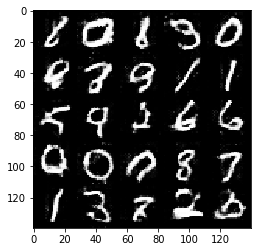

Epoch 1/2... Discriminator Loss: 1.1508... Generator Loss: 1.0422
Epoch 1/2... Discriminator Loss: 1.1252... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 0.5845
Epoch 1/2... Discriminator Loss: 1.4659... Generator Loss: 0.5499
Epoch 1/2... Discriminator Loss: 1.4388... Generator Loss: 0.5370
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.4919
Epoch 1/2... Discriminator Loss: 1.4284... Generator Loss: 0.5448
Epoch 1/2... Discriminator Loss: 1.2610... Generator Loss: 0.5066
Epoch 1/2... Discriminator Loss: 1.4289... Generator Loss: 0.3887
Epoch 1/2... Discriminator Loss: 1.6188... Generator Loss: 0.3196


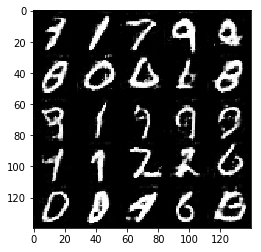

Epoch 1/2... Discriminator Loss: 1.3951... Generator Loss: 0.4423
Epoch 1/2... Discriminator Loss: 1.5350... Generator Loss: 0.3337
Epoch 1/2... Discriminator Loss: 1.4574... Generator Loss: 0.5352
Epoch 1/2... Discriminator Loss: 1.1149... Generator Loss: 0.6612
Epoch 1/2... Discriminator Loss: 1.3203... Generator Loss: 0.4903
Epoch 1/2... Discriminator Loss: 1.1703... Generator Loss: 0.8524
Epoch 1/2... Discriminator Loss: 0.8121... Generator Loss: 1.2696
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.7794
Epoch 2/2... Discriminator Loss: 1.4222... Generator Loss: 0.4022
Epoch 2/2... Discriminator Loss: 1.1769... Generator Loss: 0.7016


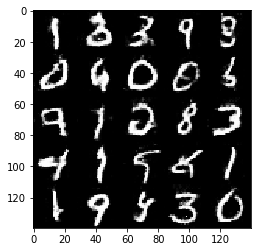

Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 0.4972
Epoch 2/2... Discriminator Loss: 1.2941... Generator Loss: 0.5462
Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 0.5934
Epoch 2/2... Discriminator Loss: 1.0929... Generator Loss: 0.7512
Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 0.6263
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 0.4250
Epoch 2/2... Discriminator Loss: 1.1176... Generator Loss: 0.7885
Epoch 2/2... Discriminator Loss: 1.7254... Generator Loss: 0.2828
Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 1.4653
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.6804


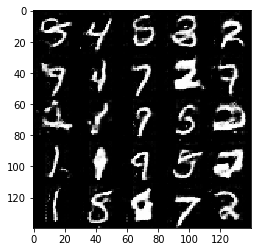

Epoch 2/2... Discriminator Loss: 1.3085... Generator Loss: 0.5258
Epoch 2/2... Discriminator Loss: 1.2325... Generator Loss: 0.8979
Epoch 2/2... Discriminator Loss: 1.3084... Generator Loss: 0.8545
Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.6138
Epoch 2/2... Discriminator Loss: 1.4486... Generator Loss: 0.4875
Epoch 2/2... Discriminator Loss: 1.1274... Generator Loss: 0.6172
Epoch 2/2... Discriminator Loss: 1.6604... Generator Loss: 0.3249
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 0.9081
Epoch 2/2... Discriminator Loss: 1.0026... Generator Loss: 1.0982
Epoch 2/2... Discriminator Loss: 1.0711... Generator Loss: 0.6301


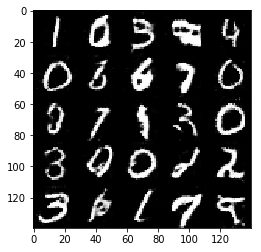

Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.5332
Epoch 2/2... Discriminator Loss: 1.4308... Generator Loss: 0.4522
Epoch 2/2... Discriminator Loss: 1.1325... Generator Loss: 0.5872
Epoch 2/2... Discriminator Loss: 1.0613... Generator Loss: 0.7929
Epoch 2/2... Discriminator Loss: 1.4630... Generator Loss: 0.4649
Epoch 2/2... Discriminator Loss: 1.0655... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 1.2368... Generator Loss: 0.5027
Epoch 2/2... Discriminator Loss: 1.5590... Generator Loss: 0.3292
Epoch 2/2... Discriminator Loss: 1.4153... Generator Loss: 0.4499
Epoch 2/2... Discriminator Loss: 1.9002... Generator Loss: 0.2490


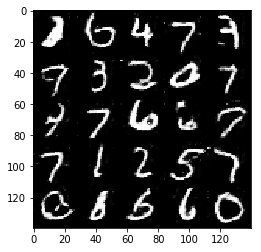

Epoch 2/2... Discriminator Loss: 1.4080... Generator Loss: 0.4077
Epoch 2/2... Discriminator Loss: 1.3924... Generator Loss: 0.8105
Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 0.6020
Epoch 2/2... Discriminator Loss: 1.0351... Generator Loss: 0.9879
Epoch 2/2... Discriminator Loss: 1.0946... Generator Loss: 0.6407
Epoch 2/2... Discriminator Loss: 1.6933... Generator Loss: 0.2785
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 0.6238
Epoch 2/2... Discriminator Loss: 1.4575... Generator Loss: 0.4609
Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 1.2397... Generator Loss: 0.7172


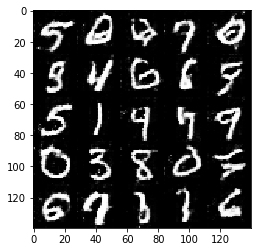

Epoch 2/2... Discriminator Loss: 1.5237... Generator Loss: 0.3769
Epoch 2/2... Discriminator Loss: 1.3255... Generator Loss: 0.5298
Epoch 2/2... Discriminator Loss: 1.1521... Generator Loss: 0.6688
Epoch 2/2... Discriminator Loss: 1.2758... Generator Loss: 0.5592
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 0.6429
Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 0.8339
Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 0.8469
Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 0.7270
Epoch 2/2... Discriminator Loss: 0.9092... Generator Loss: 1.1892
Epoch 2/2... Discriminator Loss: 0.8046... Generator Loss: 1.2002


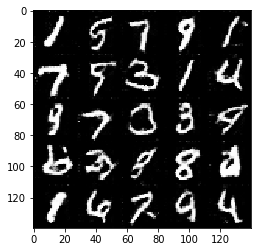

Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.4908
Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 0.5699
Epoch 2/2... Discriminator Loss: 1.1468... Generator Loss: 0.6204
Epoch 2/2... Discriminator Loss: 1.1593... Generator Loss: 0.6019
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 0.6421
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 0.5308
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.4035
Epoch 2/2... Discriminator Loss: 1.2765... Generator Loss: 0.5209
Epoch 2/2... Discriminator Loss: 1.3075... Generator Loss: 0.5152
Epoch 2/2... Discriminator Loss: 1.0576... Generator Loss: 0.7980


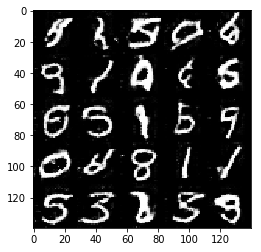

Epoch 2/2... Discriminator Loss: 1.5142... Generator Loss: 0.3633
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.4370
Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.4912... Generator Loss: 0.3575
Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 0.6877
Epoch 2/2... Discriminator Loss: 0.8962... Generator Loss: 0.9328
Epoch 2/2... Discriminator Loss: 1.0900... Generator Loss: 0.8858
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.3706... Generator Loss: 0.5334
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.5556


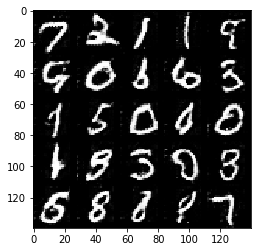

Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.4995
Epoch 2/2... Discriminator Loss: 1.0444... Generator Loss: 0.7811
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.9922
Epoch 2/2... Discriminator Loss: 1.4493... Generator Loss: 0.4234
Epoch 2/2... Discriminator Loss: 1.0119... Generator Loss: 0.8020
Epoch 2/2... Discriminator Loss: 1.6889... Generator Loss: 0.2856
Epoch 2/2... Discriminator Loss: 1.3317... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 0.4281
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 0.5702
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 0.7973


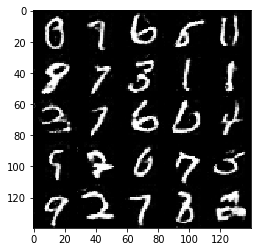

Epoch 2/2... Discriminator Loss: 1.7961... Generator Loss: 0.2422
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 0.7080
Epoch 2/2... Discriminator Loss: 1.3047... Generator Loss: 0.5686
Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 0.6681
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.5711
Epoch 2/2... Discriminator Loss: 1.0844... Generator Loss: 0.8431
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.5288
Epoch 2/2... Discriminator Loss: 1.3496... Generator Loss: 0.5715
Epoch 2/2... Discriminator Loss: 0.9308... Generator Loss: 0.8873


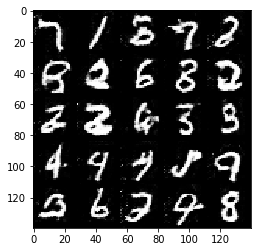

Epoch 2/2... Discriminator Loss: 1.2384... Generator Loss: 0.5428
Epoch 2/2... Discriminator Loss: 1.3084... Generator Loss: 1.0076
Epoch 2/2... Discriminator Loss: 1.0321... Generator Loss: 0.7429
Epoch 2/2... Discriminator Loss: 1.6723... Generator Loss: 0.3075
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.5609
Epoch 2/2... Discriminator Loss: 1.1791... Generator Loss: 0.6959
Epoch 2/2... Discriminator Loss: 1.2228... Generator Loss: 0.4921
Epoch 2/2... Discriminator Loss: 1.0574... Generator Loss: 0.8387
Epoch 2/2... Discriminator Loss: 1.2437... Generator Loss: 0.6586
Epoch 2/2... Discriminator Loss: 1.1070... Generator Loss: 0.6388


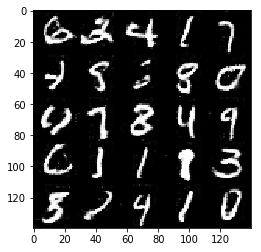

Epoch 2/2... Discriminator Loss: 0.9663... Generator Loss: 1.1418
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 0.9149
Epoch 2/2... Discriminator Loss: 1.5751... Generator Loss: 0.4334
Epoch 2/2... Discriminator Loss: 1.1737... Generator Loss: 0.6407
Epoch 2/2... Discriminator Loss: 0.9587... Generator Loss: 0.7285
Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 0.5175
Epoch 2/2... Discriminator Loss: 1.1920... Generator Loss: 0.6509
Epoch 2/2... Discriminator Loss: 1.2312... Generator Loss: 0.5874
Epoch 2/2... Discriminator Loss: 0.9435... Generator Loss: 0.7858
Epoch 2/2... Discriminator Loss: 1.2553... Generator Loss: 0.6877


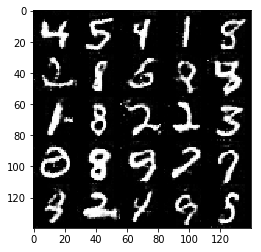

Epoch 2/2... Discriminator Loss: 1.2733... Generator Loss: 0.9035
Epoch 2/2... Discriminator Loss: 1.0740... Generator Loss: 0.8683
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 0.5846
Epoch 2/2... Discriminator Loss: 1.1102... Generator Loss: 1.0366
Epoch 2/2... Discriminator Loss: 1.0648... Generator Loss: 0.7919
Epoch 2/2... Discriminator Loss: 1.2515... Generator Loss: 0.6008
Epoch 2/2... Discriminator Loss: 1.3648... Generator Loss: 0.4830
Epoch 2/2... Discriminator Loss: 0.8617... Generator Loss: 0.9630
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.4674
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.5293


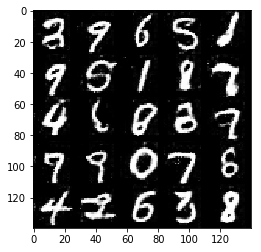

Epoch 2/2... Discriminator Loss: 1.2326... Generator Loss: 0.5137
Epoch 2/2... Discriminator Loss: 1.1136... Generator Loss: 0.6406
Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 0.5570
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 0.4981
Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 0.7701
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 0.5112
Epoch 2/2... Discriminator Loss: 1.5929... Generator Loss: 0.3875
Epoch 2/2... Discriminator Loss: 1.4430... Generator Loss: 0.4530
Epoch 2/2... Discriminator Loss: 1.0508... Generator Loss: 0.7124
Epoch 2/2... Discriminator Loss: 1.0449... Generator Loss: 0.6881


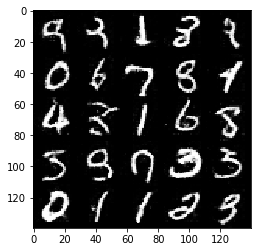

Epoch 2/2... Discriminator Loss: 0.9825... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 0.5180
Epoch 2/2... Discriminator Loss: 1.1996... Generator Loss: 0.5970
Epoch 2/2... Discriminator Loss: 1.4783... Generator Loss: 0.5308
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.6233
Epoch 2/2... Discriminator Loss: 1.0331... Generator Loss: 1.0054
Epoch 2/2... Discriminator Loss: 1.0843... Generator Loss: 0.6624
Epoch 2/2... Discriminator Loss: 1.1864... Generator Loss: 0.6210
Epoch 2/2... Discriminator Loss: 1.2469... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 1.1699... Generator Loss: 0.5879


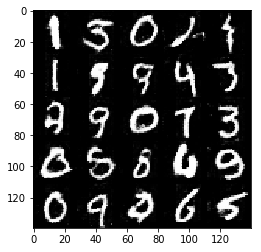

Epoch 2/2... Discriminator Loss: 1.3191... Generator Loss: 0.5543
Epoch 2/2... Discriminator Loss: 1.5272... Generator Loss: 0.4478
Epoch 2/2... Discriminator Loss: 1.1302... Generator Loss: 0.5778
Epoch 2/2... Discriminator Loss: 1.1703... Generator Loss: 0.5819
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 1.0384
Epoch 2/2... Discriminator Loss: 1.5544... Generator Loss: 0.3426
Epoch 2/2... Discriminator Loss: 1.2735... Generator Loss: 0.5465
Epoch 2/2... Discriminator Loss: 1.3262... Generator Loss: 0.5955
Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 0.7750
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 0.8225


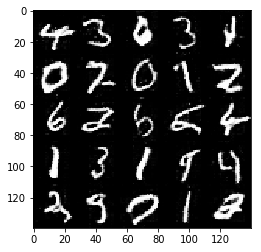

Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 0.4757
Epoch 2/2... Discriminator Loss: 1.2790... Generator Loss: 0.5219
Epoch 2/2... Discriminator Loss: 1.3171... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.0972... Generator Loss: 0.8043
Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 0.5979
Epoch 2/2... Discriminator Loss: 1.5350... Generator Loss: 0.3821
Epoch 2/2... Discriminator Loss: 1.3165... Generator Loss: 0.4908
Epoch 2/2... Discriminator Loss: 1.1537... Generator Loss: 0.7128
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 0.8643
Epoch 2/2... Discriminator Loss: 1.2158... Generator Loss: 0.6789


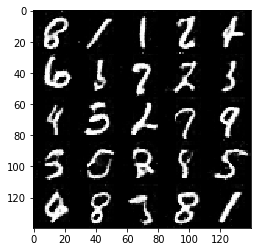

Epoch 2/2... Discriminator Loss: 1.0048... Generator Loss: 1.2460
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 0.6829
Epoch 2/2... Discriminator Loss: 1.4368... Generator Loss: 0.4373
Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 0.6093
Epoch 2/2... Discriminator Loss: 1.8924... Generator Loss: 0.2305
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 0.5505
Epoch 2/2... Discriminator Loss: 1.5795... Generator Loss: 0.3160
Epoch 2/2... Discriminator Loss: 1.3760... Generator Loss: 0.5621
Epoch 2/2... Discriminator Loss: 1.4894... Generator Loss: 0.3775
Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 0.8273


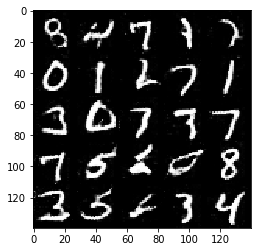

Epoch 2/2... Discriminator Loss: 1.2889... Generator Loss: 0.5673
Epoch 2/2... Discriminator Loss: 1.4026... Generator Loss: 0.4409
Epoch 2/2... Discriminator Loss: 1.3618... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 1.3124... Generator Loss: 0.5176
Epoch 2/2... Discriminator Loss: 1.1113... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.4414
Epoch 2/2... Discriminator Loss: 1.2136... Generator Loss: 1.0753
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 0.5151
Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 0.5354
Epoch 2/2... Discriminator Loss: 1.5990... Generator Loss: 0.3602


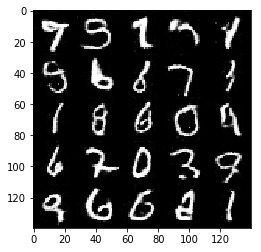

Epoch 2/2... Discriminator Loss: 1.2491... Generator Loss: 0.5620
Epoch 2/2... Discriminator Loss: 1.1912... Generator Loss: 0.5760
Epoch 2/2... Discriminator Loss: 1.4104... Generator Loss: 0.4676
Epoch 2/2... Discriminator Loss: 1.5488... Generator Loss: 0.3598
Epoch 2/2... Discriminator Loss: 0.9812... Generator Loss: 0.8784


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1134... Generator Loss: 3.7203
Epoch 1/1... Discriminator Loss: 0.3649... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 0.0697... Generator Loss: 3.4016
Epoch 1/1... Discriminator Loss: 0.0440... Generator Loss: 3.6894
Epoch 1/1... Discriminator Loss: 0.0952... Generator Loss: 3.3480
Epoch 1/1... Discriminator Loss: 0.0825... Generator Loss: 3.2296
Epoch 1/1... Discriminator Loss: 0.2252... Generator Loss: 2.0334
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 2.3882
Epoch 1/1... Discriminator Loss: 0.0729... Generator Loss: 3.3641
Epoch 1/1... Discriminator Loss: 0.0987... Generator Loss: 3.3702


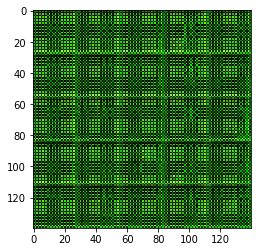

Epoch 1/1... Discriminator Loss: 0.1790... Generator Loss: 2.2835
Epoch 1/1... Discriminator Loss: 0.0584... Generator Loss: 3.5029
Epoch 1/1... Discriminator Loss: 0.0365... Generator Loss: 4.3717
Epoch 1/1... Discriminator Loss: 0.0394... Generator Loss: 4.2446
Epoch 1/1... Discriminator Loss: 0.6228... Generator Loss: 3.3039
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 2.2658
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 2.2520
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 1.0757
Epoch 1/1... Discriminator Loss: 2.7980... Generator Loss: 0.0782
Epoch 1/1... Discriminator Loss: 1.8801... Generator Loss: 0.2746


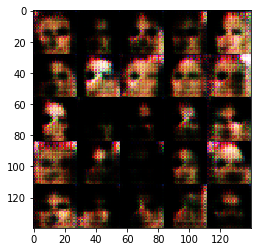

Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.1930
Epoch 1/1... Discriminator Loss: 1.7490... Generator Loss: 0.2586
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.5995... Generator Loss: 0.3110
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 2.3573
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 1.6695
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 1.7739
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 1.6689


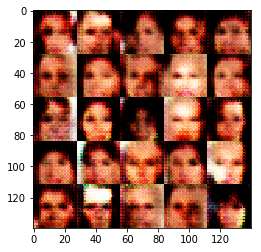

Epoch 1/1... Discriminator Loss: 1.6297... Generator Loss: 0.4002
Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 1.5340
Epoch 1/1... Discriminator Loss: 1.8634... Generator Loss: 0.3972
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 2.7053
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 1.9798... Generator Loss: 0.1916
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.4562
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.0170


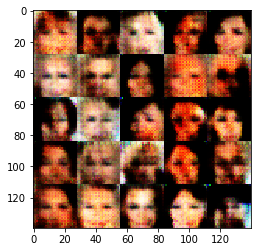

Epoch 1/1... Discriminator Loss: 1.6154... Generator Loss: 0.4429
Epoch 1/1... Discriminator Loss: 0.6445... Generator Loss: 2.0508
Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.6454... Generator Loss: 0.4147
Epoch 1/1... Discriminator Loss: 1.6693... Generator Loss: 0.4596
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 1.0489
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 1.2932
Epoch 1/1... Discriminator Loss: 1.7223... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 2.9052
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.5539


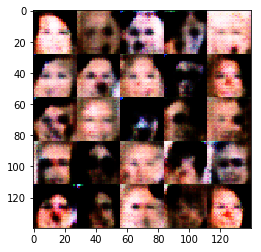

Epoch 1/1... Discriminator Loss: 0.8052... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.3383
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.6718... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.7371


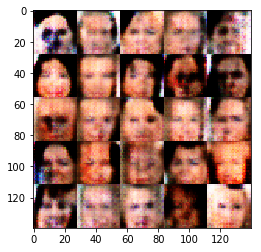

Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.3493
Epoch 1/1... Discriminator Loss: 1.6284... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 1.5701... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.5647
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 1.7482... Generator Loss: 0.3374
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 1.5526... Generator Loss: 0.9322


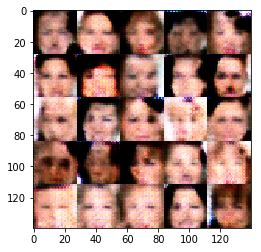

Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.4588
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.9801
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.8277... Generator Loss: 0.5489
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.6683


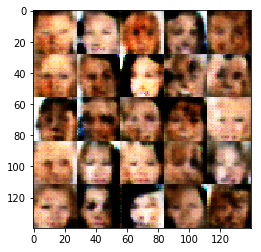

Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.4678
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.5007
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.2249
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.5941... Generator Loss: 0.4753


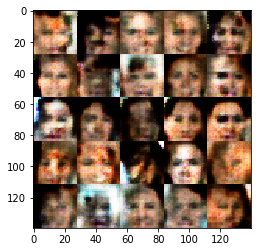

Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.6548


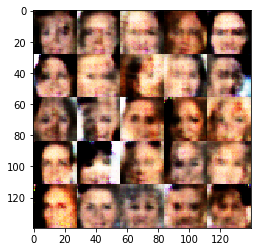

Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.4818
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.5944... Generator Loss: 0.4347
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.4888
Epoch 1/1... Discriminator Loss: 1.6564... Generator Loss: 0.4786
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.6926... Generator Loss: 0.3441


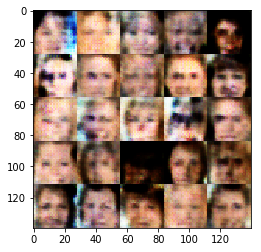

Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.6926... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.6379... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.5958


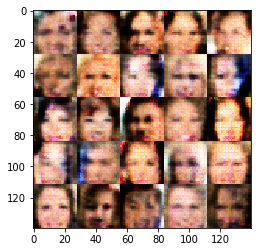

Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7350


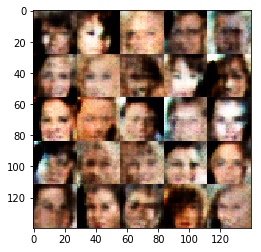

Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 0.4807
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6171


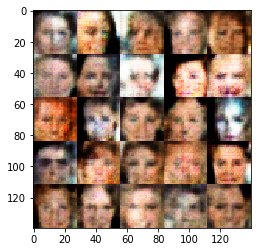

Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6841


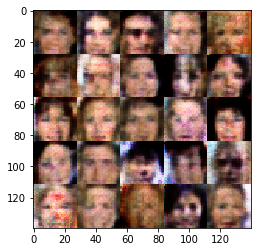

Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.6634


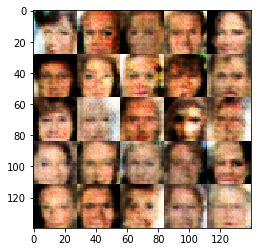

Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6419


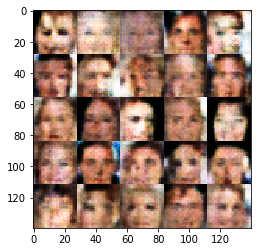

Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6172


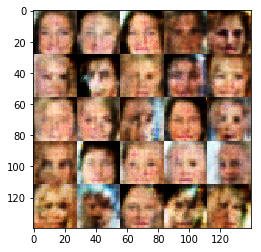

Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.6087


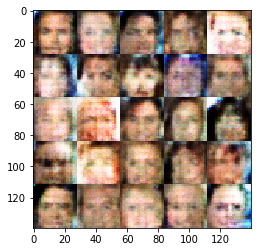

Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.5935


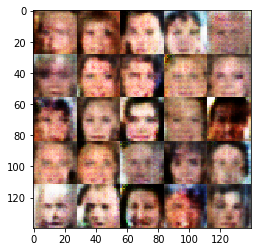

Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.6426


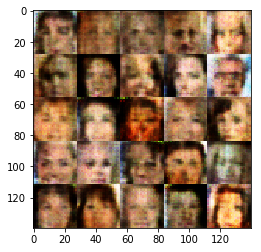

Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.6257


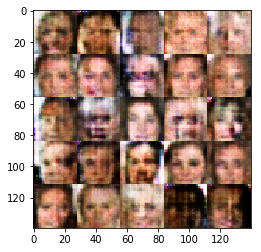

Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6882


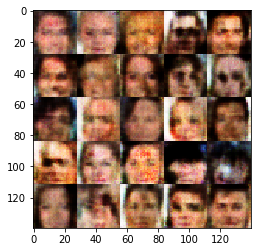

Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6350


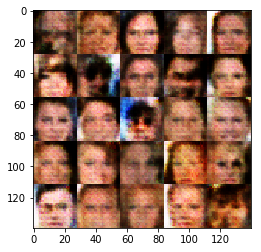

Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6756


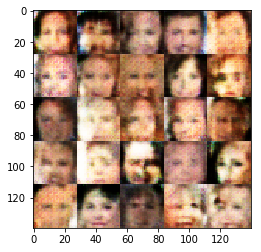

Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.6303


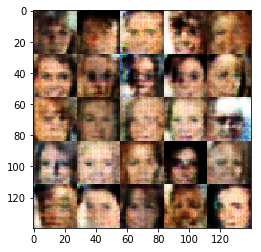

Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6633


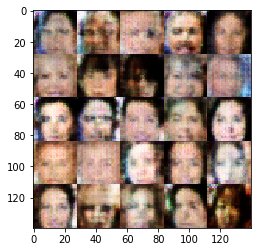

Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.6602


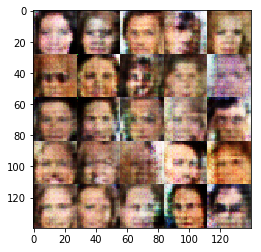

Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6670


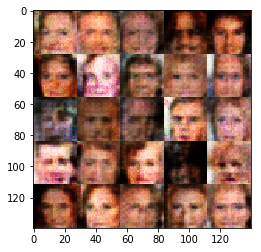

Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6310


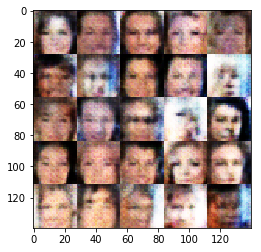

Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6381


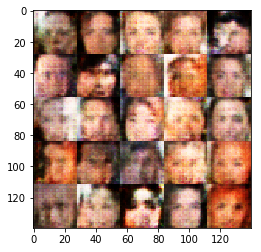

Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.6842


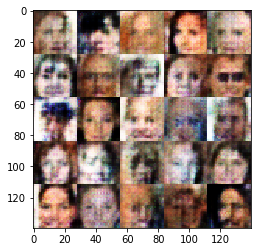

Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6618


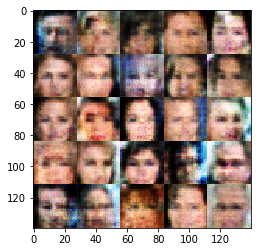

Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.6161


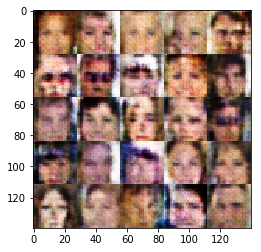

Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6315


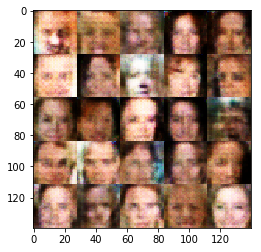

Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6574


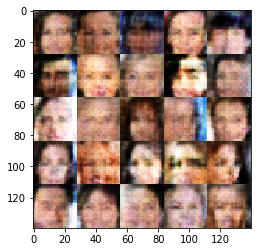

Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6635


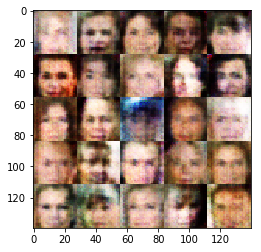

Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6704


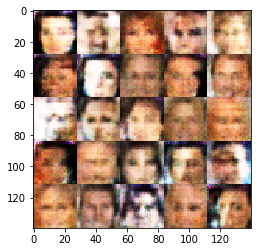

Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6889


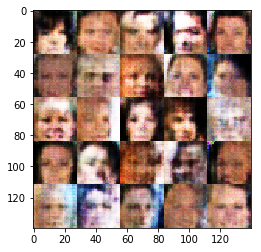

Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6727


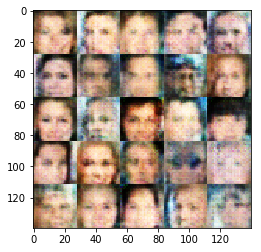

Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6807


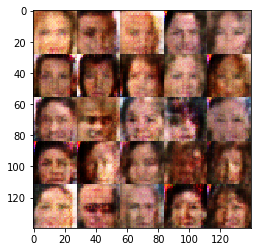

Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6441


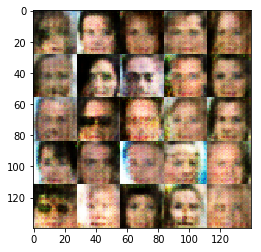

Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6670


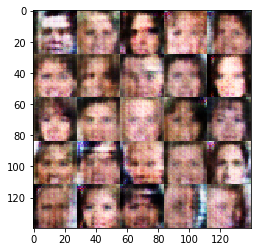

Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6782


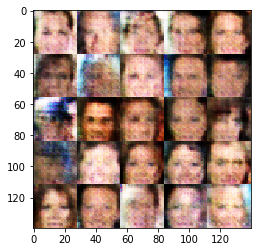

Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.6657


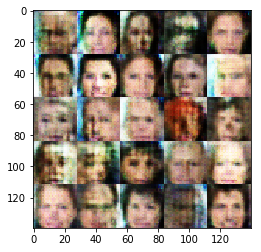

Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6626


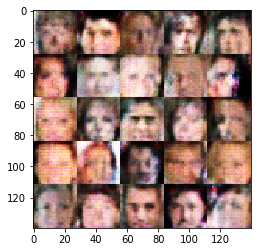

Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6728


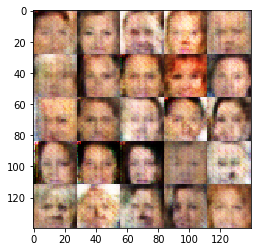

Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6994


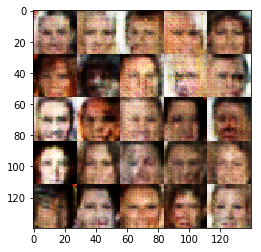

Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7023


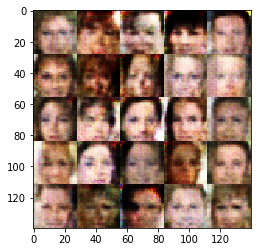

Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7030


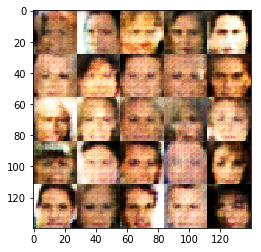

Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.6948


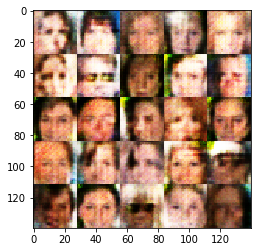

Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6895


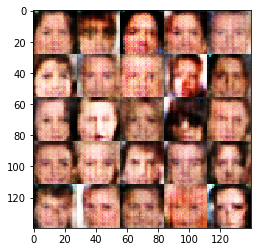

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6732


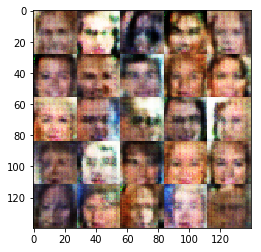

Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6769


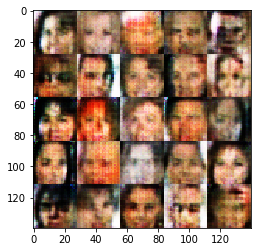

Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6608


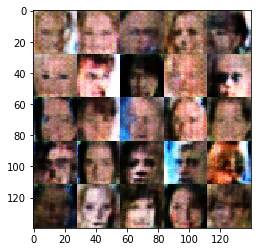

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6636


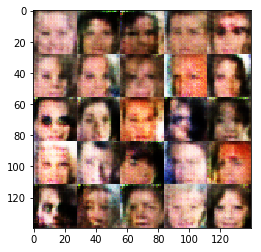

Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6726


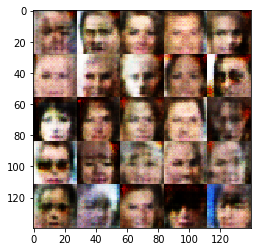

Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6510


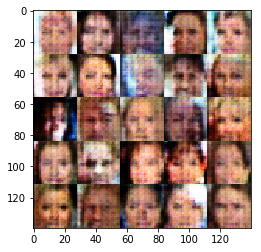

Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6743


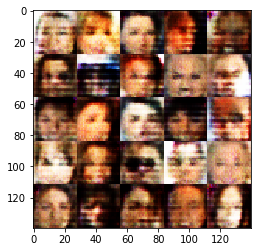

Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.6855


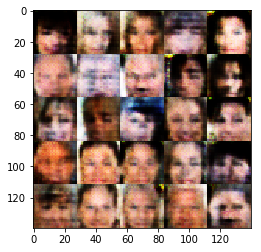

Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6629


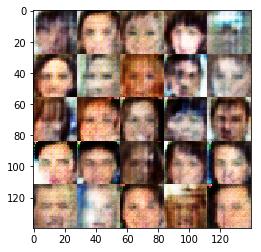

Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6736


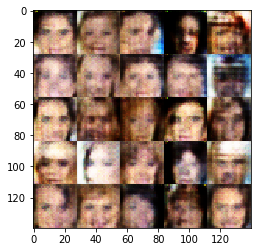

Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6760


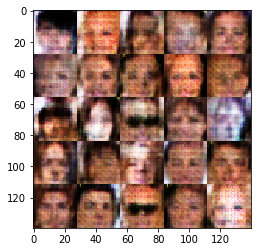

Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6793


In [33]:
batch_size = 32
#batch_size = 128
z_dim = 100
learning_rate = 0.0008
#learning_rate = 0.0001, 0.0008, 0.002
beta1 = 0.4
#beta1 = 0.2, 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.